In [50]:
from __future__ import print_function
import warnings
import pickle
import numpy as np
import pandas as pd
from fbprophet import Prophet
import statsmodels.api as sm
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score as R2
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.close('all')
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [41]:
filename = 'stackedPeds.sav'
trainPeds = pickle.load(open(filename, 'rb'))

filename = 'stackedCycs.sav'
trainCycs = pickle.load(open(filename, 'rb'))

filename = 'testInts.sav'
testInts = pickle.load(open(filename, 'rb')) # Hold-out intersection IDs

In [42]:
yLabels = ['Pedestrian volume','Cyclist volume']

In [43]:
#Extracting the intersections used for training
allInts = list(np.arange(0,14)) #all intersections
trainInts = list(set(allInts) - set(testInts)) #trained intersections

In [44]:
RoadUser = ['Pedestrians', 'Cyclists']

trafficData = [Pedestrians, Cyclists]

In [ ]:
trainStart = pd.to_datetime('2019-05-01 00:00:00');
trainEnd = pd.to_datetime('2019-06-30 23:00:00');

testStart = pd.to_datetime('2019-07-01 00:00:00');
testEnd = pd.to_datetime('2019-07-31 23:00:00');

Adelaide / Jarvis Intersection: Pedestrians


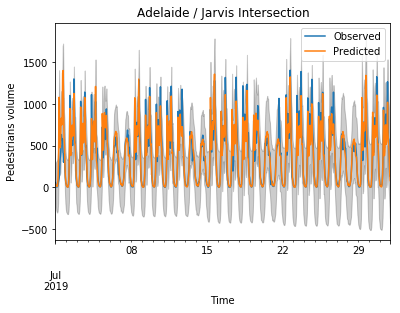

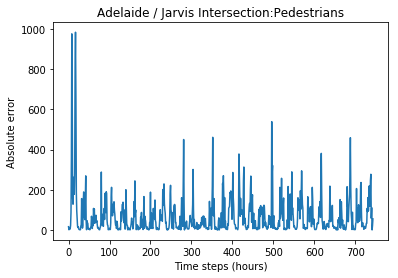

MAE: 67.9247311827957
R_Squared: 0.8606788745707805
Front / Bathurst Intersection: Pedestrians


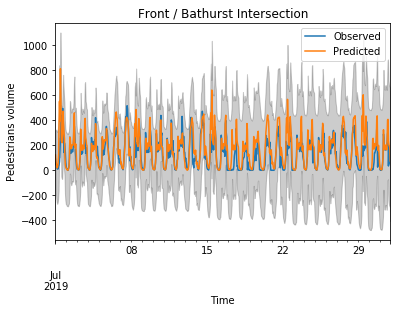

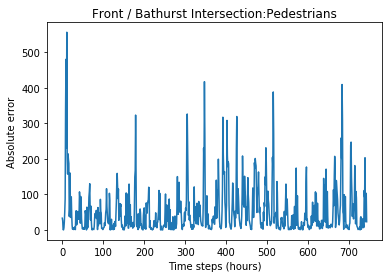

MAE: 53.81182795698925
R_Squared: 0.5856927678319103
King / Portland Intersection: Pedestrians


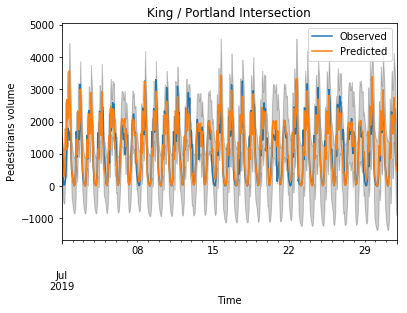

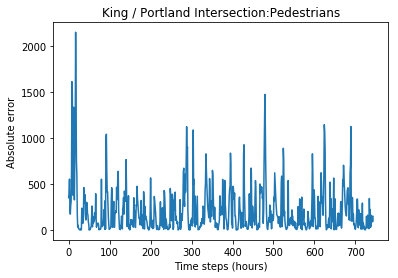

MAE: 209.69354838709677
R_Squared: 0.8531891833421892
King / Bay Intersection: Pedestrians


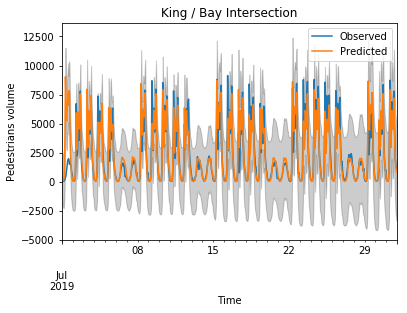

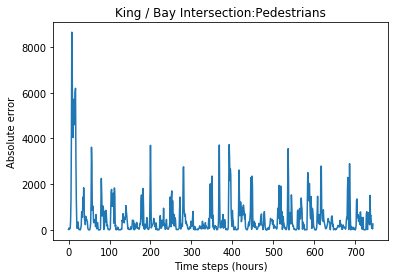

MAE: 517.6034946236559
R_Squared: 0.8071243734214172
King / Yonge Intersection: Pedestrians


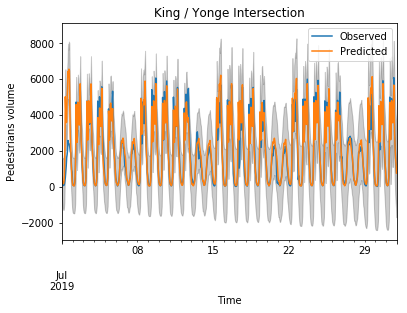

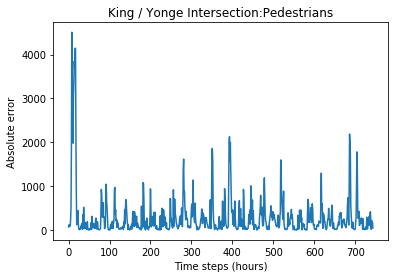

MAE: 289.71774193548384
R_Squared: 0.8849080822351624
King / Jarvis Intersection: Pedestrians


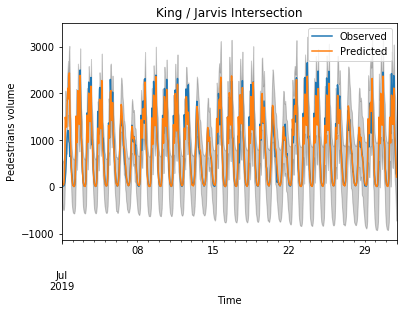

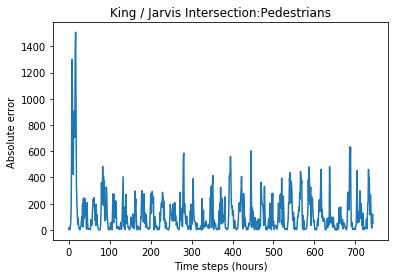

MAE: 116.88844086021506
R_Squared: 0.9111618688409739
Richmond / Spadina Intersection: Pedestrians


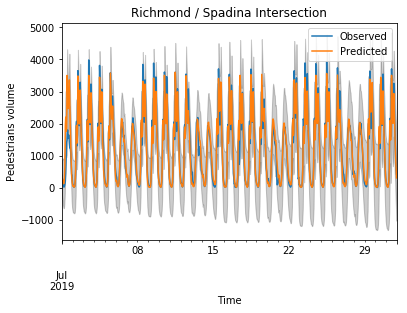

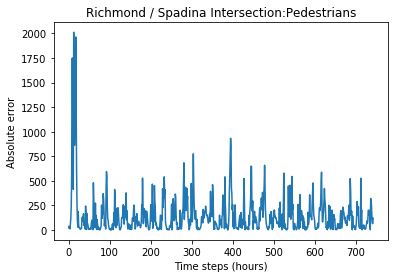

MAE: 146.0497311827957
R_Squared: 0.9377527377174054
Richmond / Bay Intersection: Pedestrians


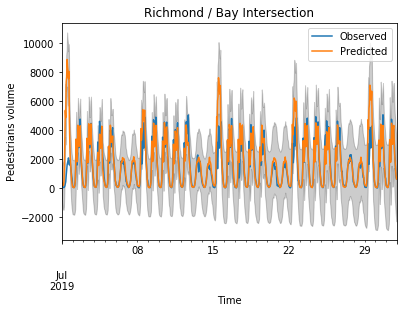

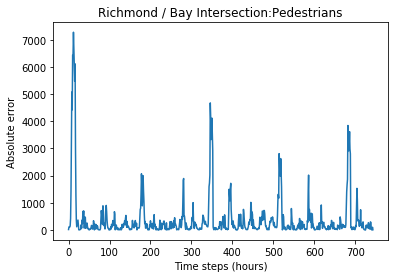

MAE: 390.77150537634407
R_Squared: 0.6783550424868312
Wellington / Blue Jays Intersection: Pedestrians


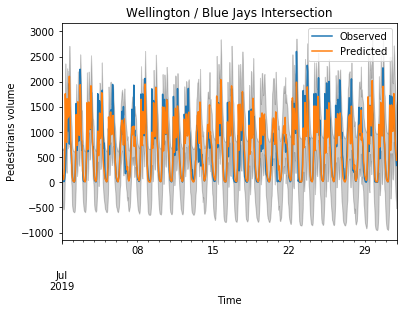

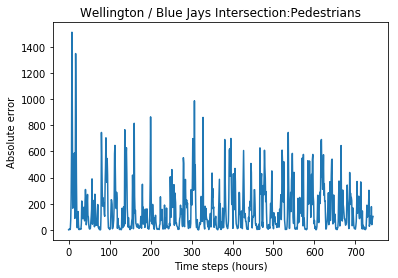

MAE: 158.16532258064515
R_Squared: 0.7893881017261183
King / John Intersection: Pedestrians


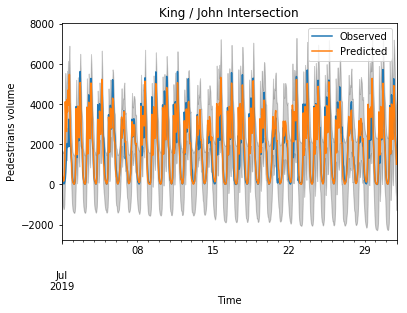

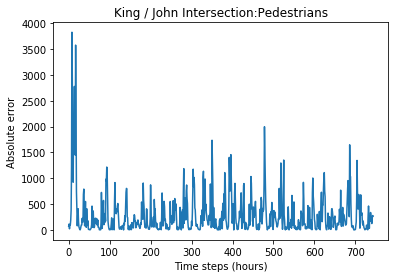

MAE: 289.2096774193548
R_Squared: 0.8864231953677449
Adelaide / Jarvis Intersection: Cyclists


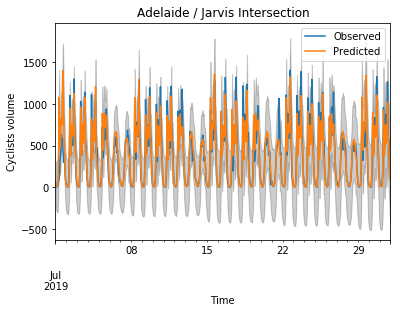

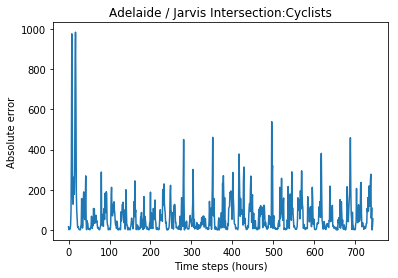

MAE: 67.9247311827957
R_Squared: 0.8606788745707805
Front / Bathurst Intersection: Cyclists


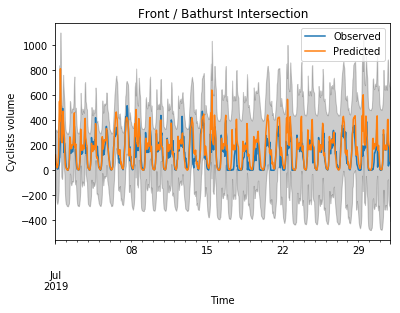

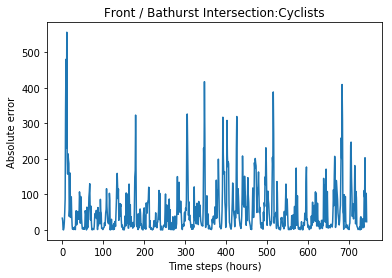

MAE: 53.81182795698925
R_Squared: 0.5856927678319103
King / Portland Intersection: Cyclists


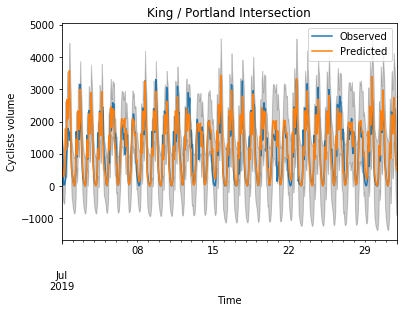

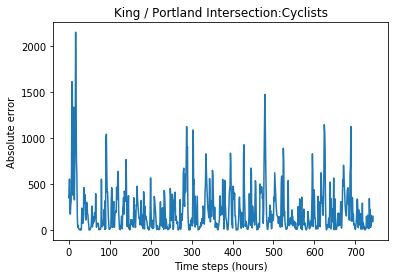

MAE: 209.69354838709677
R_Squared: 0.8531891833421892
King / Bay Intersection: Cyclists


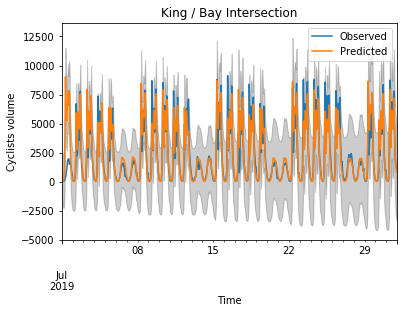

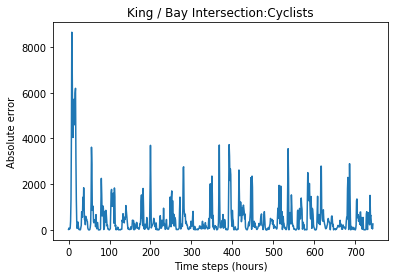

MAE: 517.6034946236559
R_Squared: 0.8071243734214172
King / Yonge Intersection: Cyclists


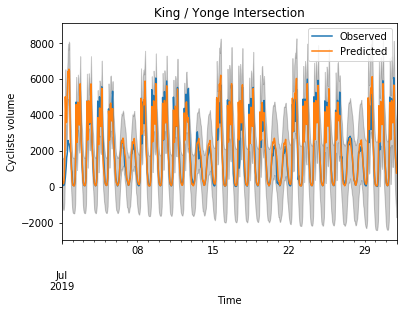

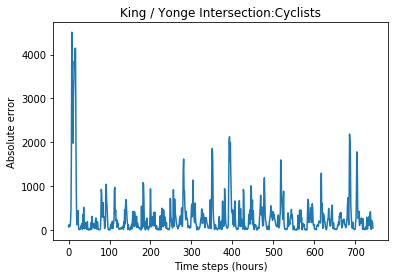

MAE: 289.71774193548384
R_Squared: 0.8849080822351624
King / Jarvis Intersection: Cyclists


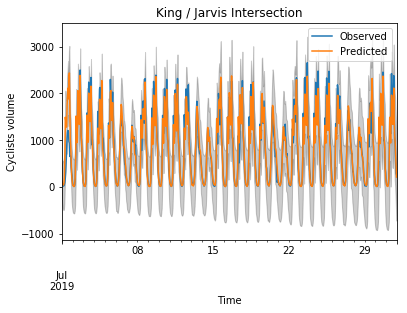

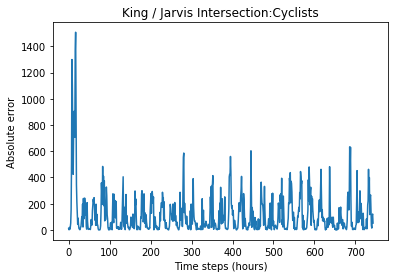

MAE: 116.88844086021506
R_Squared: 0.9111618688409739
Richmond / Spadina Intersection: Cyclists


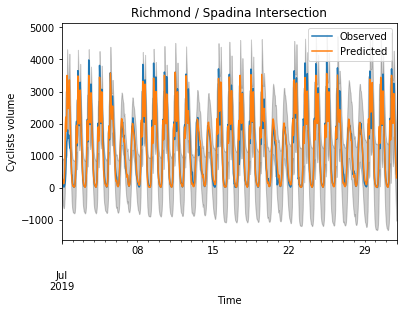

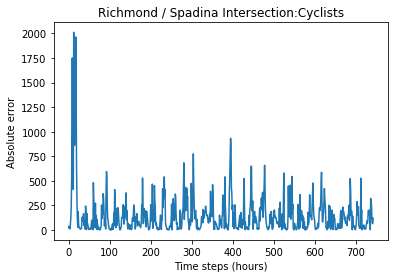

MAE: 146.0497311827957
R_Squared: 0.9377527377174054
Richmond / Bay Intersection: Cyclists


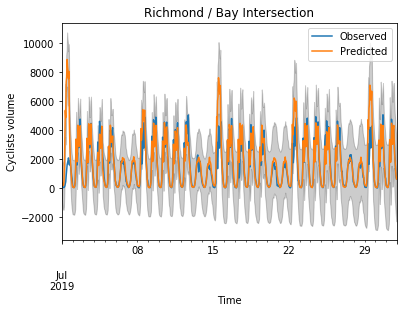

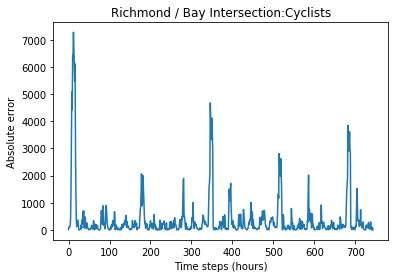

MAE: 390.77150537634407
R_Squared: 0.6783550424868312
Wellington / Blue Jays Intersection: Cyclists


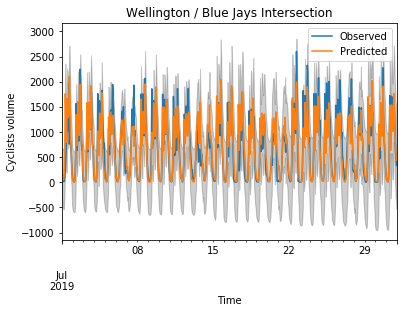

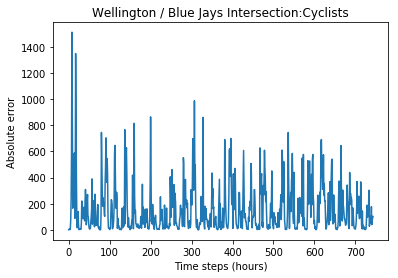

MAE: 158.16532258064515
R_Squared: 0.7893881017261183
King / John Intersection: Cyclists


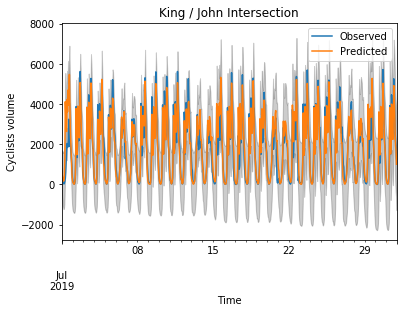

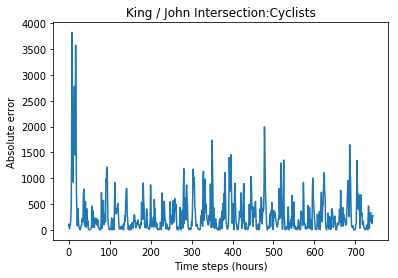

MAE: 289.2096774193548
R_Squared: 0.8864231953677449


In [55]:
R2_ARIMA = []; MAE_ARIMA = [];
for j in range(2):
    
    userData = trafficData[j]    
    
    for k in trainInts:
        
        trafficVols = userData[k];
        
        IntersectionName = trafficVols['IntName'][0]
               
        trainData = trafficVols[trainStart: trainEnd][['volume','Hour','DayOfWeek','isHoliday']];
        trainData = trainData.dropna()
        
        testData = trafficVols[testStart: testEnd][['volume','Hour','DayOfWeek','isHoliday']];
        testData = testData.dropna()
        
        X_train = trainData[['Hour','DayOfWeek','isHoliday']];     
        y_train = trainData['volume']
      
        X_test = testData[['Hour','DayOfWeek','isHoliday']];     
        y_test = testData['volume']
    
        #ARIMA model
        non_seasonal = (1,0,1); seasonal = (1,1,0,24*7); #Optimal in terms of AIC
    
        exog = X_train; #Exogenous inputs
    
        arimaMdl = sm.tsa.statespace.SARIMAX(y_train,
        order = non_seasonal, seasonal_order = seasonal,
        enforce_stationarity = False, enforce_invertibility = False)
    
        arimaMdl = arimaMdl.fit(disp=0)
        
        forecasts = arimaMdl.get_prediction(start=testStart, end=testEnd)
        
        yPred = forecasts.predicted_mean;
        yPred = round(yPred); yPred[yPred<0]=0;      
        yPred = pd.DataFrame(yPred, columns =['forecast']); 
        yPred.index = y_test.index; yPred = yPred['forecast'];
        
        yLow = forecasts.conf_int().iloc[:,0]
        
        yHigh = forecasts.conf_int().iloc[:,1]
        
        r_squared = R2(yPred, y_test)
        mae = MAE(yPred, y_test)
        
        R2_ARIMA.append(r_squared)
        MAE_ARIMA.append(mae)
        
        print(IntersectionName + ' Intersection: '+ RoadUser[j])

        #Plotting for the test dates          
        ax = y_test.plot(label = 'Observed')
        yPred.plot(ax = ax, label = 'Predicted')
        ax.fill_between(y_test.index,
                            yLow,
        yHigh, color='k', alpha=.2)
        ax.set_xlabel('Time')
        ax.set_ylabel(RoadUser[j] + ' volume')
        ax.set_title(IntersectionName + ' Intersection')
        plt.legend()
        plt.show()
        
        #Showing the evolution of the forecast error with time
        AbsErr = np.abs(yPred.values - y_test.values)
        plt.plot(AbsErr); 
        plt.xlabel('Time steps (hours)'); plt.ylabel('Absolute error')
        plt.title(IntersectionName + ' Intersection:' + RoadUser[j])
        plt.show()
                    
        print('MAE: '+ str(mae))
        print('R_Squared: '+str(r_squared))
        print('\n')

Plotting the results